In [0]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt


In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [0]:
# Transforms
data_aug_transforms = []

possible_transforms = []


possible_transforms.append(torchvision.transforms.RandomHorizontalFlip(p=1.))


possible_transforms.append(torchvision.transforms.RandomCrop(size=32, padding=None, 
                                                             pad_if_needed=True, fill=0, 
                                                             padding_mode='constant'))

data_aug_transforms.append(torchvision.transforms.RandomChoice(possible_transforms))

final_transform = transforms.Compose(data_aug_transforms+[transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                     ])

In [0]:
transform = transforms.Compose([
    # you can add other transformations in this list
    transforms.ToTensor()
])

In [0]:
cifar_dataset = torchvision.datasets.CIFAR10(root='datasets/',
                                           train=True,
                                           transform = final_transform,
                                           download=True)

Files already downloaded and verified


In [0]:
cifar_dataset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: datasets/
    Split: Train

In [0]:
test_dataset = torchvision.datasets.CIFAR10(root='datasets/',
                                          train=False,
                                            transform = transform
                                          
                                          )

In [0]:
test_dataset

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: datasets/
    Split: Test

In [0]:
# Variable Declarations

input_size = 3
num_classes = 10
hidden_size = [128, 512, 512, 512, 1024]
num_epochs = 30
batch_size = 200
learning_rate = 2e-3
learning_rate_decay = 0.95
reg = 0.001
num_training = 48000
num_validation = 2000
norm_layer = True

In [0]:
# Splitting into Validation and Training set

mask = list(range(num_training))
train_dataset = torch.utils.data.Subset(cifar_dataset, mask)
mask = list(range(num_training, num_training + num_validation))
val_dataset = torch.utils.data.Subset(cifar_dataset, mask)

In [0]:
# Standard Data Loaders for Pytorch
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                           batch_size=batch_size,
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=1,
                                          shuffle=False)

In [0]:
def weights_init(m):
    if type(m) == nn.Linear:
        m.weight.data.normal_(0.0, 1e-3)
        m.bias.data.fill_(0.)      
        

class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)
      
def update_lr(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [0]:
# Class definition
class ConvNet(nn.Module):
  def __init__(self, input_size, hidden_layers, num_classes, norm_layer=None, dropout_p=0.3):
      super(ConvNet, self).__init__()
      layers = []
      cur_size = 32
      cur_filter_size = 3
      last_channel_count = input_size
      for i, current_channel_count in enumerate(hidden_layers):
          cur_padding = cur_size - 1 + cur_filter_size
          cur_padding = int((cur_padding - cur_size) / 2 )
          layers.append(nn.Conv2d(in_channels=last_channel_count, out_channels=current_channel_count, kernel_size=(3, 3), padding=cur_padding))
          if norm_layer:
            layers.append(nn.BatchNorm2d(current_channel_count))
          layers.append(nn.MaxPool2d(kernel_size=(2, 2), stride=2))
          layers.append(nn.ReLU())
          layers.append(nn.Dropout(p=dropout_p))
          last_channel_count = current_channel_count
          cur_size = int(cur_size / 2)
      o = Flatten()
      layers.append(Flatten())
      layers.append(nn.Linear(in_features=hidden_layers[-1], out_features=num_classes))
      self.layers = nn.Sequential(*layers)
  def forward(self, x):
    forward_out = self.layers(x)
    return forward_out
      

In [0]:
model = ConvNet(input_size, hidden_size, num_classes, norm_layer=norm_layer, dropout_p=0.1).to(device)
model_loss = []
early_stopping_data = {"model": None, "val_acc": 0, "epoch": 0}
model.apply(weights_init)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=reg)
print(model)



ConvNet(
  (layers): Sequential(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): ReLU()
    (4): Dropout(p=0.1)
    (5): Conv2d(128, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): ReLU()
    (9): Dropout(p=0.1)
    (10): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): ReLU()
    (14): Dropout(p=0.1)
    (15): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)

In [0]:
train_accs = []
val_accs = []

In [0]:
# Training the model

lr = learning_rate
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        #print("Inside the loop")
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)

        loss = criterion(outputs, labels)
        model_loss.append(loss)

        optimizer.zero_grad()
        #print("Gradient calculation")
        loss.backward()
        #print("Backward")
        optimizer.step()
        #print("OPtimizer")
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

    lr *= learning_rate_decay
    update_lr(optimizer, lr)
    model.eval()
    with torch.no_grad():

        correct = 0
        total = 0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_acc = correct / total
        train_accs.append(train_acc)
        print('Training accuracy is: {} %'.format(100 * train_acc))

        correct = 0
        total = 0
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        val_acc = correct / total
        val_accs.append(val_acc)
        print('Validataion accuracy is: {} %'.format(100 * val_acc))
        
        
        # Early stopping
        if val_acc > early_stopping_data["val_acc"]:

            early_stopping_data["model"] = model.state_dict()
            early_stopping_data["val_acc"] = val_acc
            early_stopping_data["epoch"] = epoch + 1

            torch.save(early_stopping_data, "final_1024_0.1.ckpt")
        

    model.train()

Epoch [1/30], Step [100/240], Loss: 1.2997
Epoch [1/30], Step [200/240], Loss: 1.0307
Training accuracy is: 53.58541666666666 %
Validataion accuracy is: 52.949999999999996 %
Epoch [2/30], Step [100/240], Loss: 0.8918
Epoch [2/30], Step [200/240], Loss: 0.9544
Training accuracy is: 65.21875 %
Validataion accuracy is: 64.25 %
Epoch [3/30], Step [100/240], Loss: 0.7202
Epoch [3/30], Step [200/240], Loss: 0.7913
Training accuracy is: 72.3875 %
Validataion accuracy is: 70.89999999999999 %
Epoch [4/30], Step [100/240], Loss: 0.5707
Epoch [4/30], Step [200/240], Loss: 0.7075
Training accuracy is: 73.90208333333334 %
Validataion accuracy is: 72.05 %
Epoch [5/30], Step [100/240], Loss: 0.4918
Epoch [5/30], Step [200/240], Loss: 0.7528
Training accuracy is: 73.1125 %
Validataion accuracy is: 71.5 %
Epoch [6/30], Step [100/240], Loss: 0.6208
Epoch [6/30], Step [200/240], Loss: 0.6037
Training accuracy is: 81.40625 %
Validataion accuracy is: 77.8 %
Epoch [7/30], Step [100/240], Loss: 0.5223
Epoch 

In [0]:

trained_model = torch.load("final_1024_0.1.ckpt")


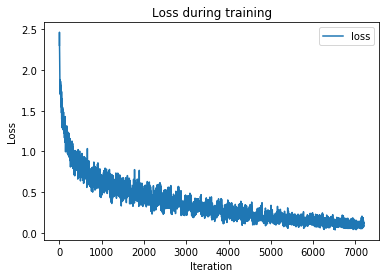

In [0]:
plt.plot(model_loss, label='loss')
plt.title('Loss during training')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.savefig('loss.png')

plt.show()


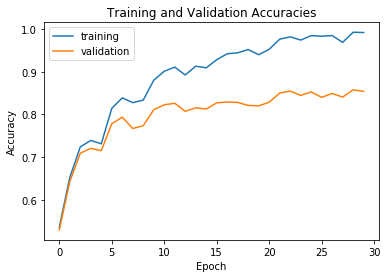

In [0]:
# plot the accuracy curves of the model
plt.plot(train_accs, label="training")
plt.plot(val_accs, label="validation")
plt.title('Training and Validation Accuracies')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('accuracy.png')

plt.show()


In [0]:
trained_model['val_acc']

0.8575

In [0]:

from torch.autograd import Variable


In [0]:
model.load_state_dict(trained_model["model"])

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [0]:
# Testing the model on test set

model.eval()

with torch.no_grad():
  correct = 0
  total = 0 
  count = 1
  for  i,image in enumerate(test_dataset):
    
    if count <= 10000:
      #print( "real op", image[1])
      #image = image.to(device)
      #image_tensor = test_transforms(image).float()
      #im = Variable(image[0])
      
      image_tensor = image[0].unsqueeze_(0)
      im = image_tensor.to(device)
      #im = Variable(image[0])
      output = model(im)
      #print(image,output)
      _, predicted = torch.max(output.data, 1)
      #print(predicted.data.cpu().numpy()[0])
      if(image[1] == predicted.data.cpu().numpy()[0]):
        correct += 1
    count += 1
    if count == 10000:
      print(correct)
      break

8377


In [0]:

with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        for i in images:
          im = i.unsqueeze_(0)
          outputs = model(im)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
          print("p", predicted, "l",labels)
        if total == 10000:
            break
    print('Accuracy of the network on the {} test images: {} %'.format(total, 100 * correct / total))

p tensor([3], device='cuda:0') l tensor([3], device='cuda:0')
p tensor([8], device='cuda:0') l tensor([8], device='cuda:0')
p tensor([3], device='cuda:0') l tensor([8], device='cuda:0')
p tensor([3], device='cuda:0') l tensor([0], device='cuda:0')
p tensor([6], device='cuda:0') l tensor([6], device='cuda:0')
p tensor([6], device='cuda:0') l tensor([6], device='cuda:0')
p tensor([3], device='cuda:0') l tensor([1], device='cuda:0')
p tensor([4], device='cuda:0') l tensor([6], device='cuda:0')
p tensor([3], device='cuda:0') l tensor([3], device='cuda:0')
p tensor([6], device='cuda:0') l tensor([1], device='cuda:0')
p tensor([3], device='cuda:0') l tensor([0], device='cuda:0')
p tensor([9], device='cuda:0') l tensor([9], device='cuda:0')
p tensor([5], device='cuda:0') l tensor([5], device='cuda:0')
p tensor([7], device='cuda:0') l tensor([7], device='cuda:0')
p tensor([8], device='cuda:0') l tensor([9], device='cuda:0')
p tensor([8], device='cuda:0') l tensor([8], device='cuda:0')
p tensor

KeyboardInterrupt: ignored